In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import shutil

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
import torchvision.models as models
from torch import optim
import torch.nn.functional as F

In [ ]:
# Define paths
data_dir = "drive/My Drive/CoLab/ACPS/PlantPersona_data/Wheat/RGB/"
train_dir = "./Wheat_RGB_training"
test_dir = "./Wheat_RGB_testing"

# Create train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the ratio of training to testing data
train_ratio = 0.8

# Loop through each folder (P1 to P4)
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        # Create corresponding folders in train and test directories
        train_folder_path = os.path.join(train_dir, folder_name)
        test_folder_path = os.path.join(test_dir, folder_name)
        os.makedirs(train_folder_path, exist_ok=True)
        os.makedirs(test_folder_path, exist_ok=True)

        # List all files in the folder
        files = os.listdir(folder_path)
        # Shuffle the list of files
        random.shuffle(files)

        # Split files into train and test sets
        num_train = int(len(files) * train_ratio)
        train_files = files[:num_train]
        test_files = files[num_train:]

        # Move train files to train directory
        for file_name in train_files:
            src = os.path.join(folder_path, file_name)
            dst = os.path.join(train_folder_path, file_name)
            shutil.copy(src, dst)

        # Move test files to test directory
        for file_name in test_files:
            src = os.path.join(folder_path, file_name)
            dst = os.path.join(test_folder_path, file_name)
            shutil.copy(src, dst)

print("Data splitting completed successfully.")

Data splitting completed successfully.


In [ ]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Plot')
    plt.show()

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        # Grayscale
        # img0 = img0.convert("L")
        # img1 = img1.convert("L")

        # RGB
        img0 = Image.open(img0_tuple[0]).convert("RGB")
        img1 = Image.open(img1_tuple[0]).convert("RGB")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./Wheat_RGB_training/")

In [ ]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


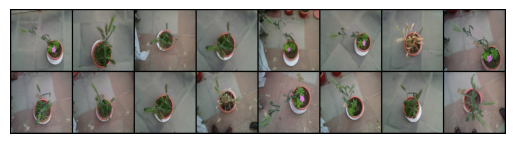

[1. 0. 0. 1. 0. 0. 1. 1.]


In [ ]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [ ]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
      # manhattan_distance = torch.norm(output1 - output2, p=1, dim=1)
      # kl_divergence = F.kl_div(F.log_softmax(output1, dim=1), F.softmax(output2, dim=1), reduction='batchmean')

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
      # loss_contrastive = torch.mean((1-label) * torch.pow(manhattan_distance, 2) +
      #                               (label) * torch.pow(torch.clamp(self.margin - manhattan_distance, min=0.0), 2))
      # loss_contrastive = torch.mean((1-label) * torch.pow(kl_divergence, 2) +
      #                               (label) * torch.pow(torch.clamp(self.margin - kl_divergence, min=0.0), 2))


      return loss_contrastive

In [ ]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001 )

In [ ]:
counter = []
loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 1

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())


Epoch number 0
 Current loss 1.8729156255722046

Epoch number 1
 Current loss 1.8343424797058105

Epoch number 2
 Current loss 1.6685681343078613

Epoch number 3
 Current loss 1.2230008840560913

Epoch number 4
 Current loss 1.2644133567810059

Epoch number 5
 Current loss 1.4315341711044312

Epoch number 6
 Current loss 0.9000598192214966

Epoch number 7
 Current loss 0.9359287619590759

Epoch number 8
 Current loss 0.671331524848938

Epoch number 9
 Current loss 0.9363877773284912

Epoch number 10
 Current loss 0.9852554798126221

Epoch number 11
 Current loss 0.9048587083816528

Epoch number 12
 Current loss 0.652979850769043

Epoch number 13
 Current loss 0.8303177952766418

Epoch number 14
 Current loss 0.7359866499900818

Epoch number 15
 Current loss 0.913307785987854

Epoch number 16
 Current loss 0.6604173183441162

Epoch number 17
 Current loss 0.6072795987129211

Epoch number 18
 Current loss 0.5843873023986816

Epoch number 19
 Current loss 0.7143422365188599

Epoch number 

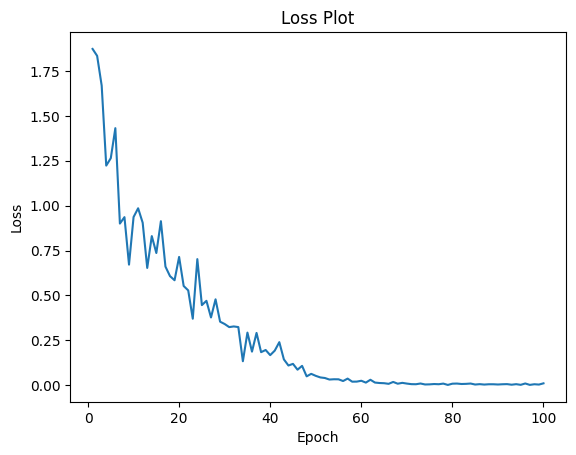

In [ ]:
# Loss Plot
show_plot(counter, loss_history)

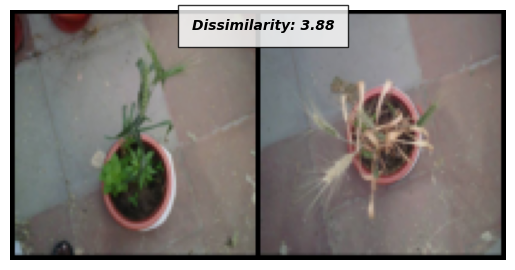

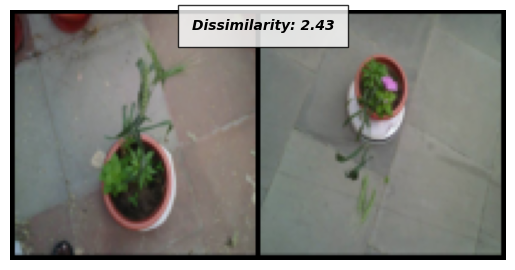

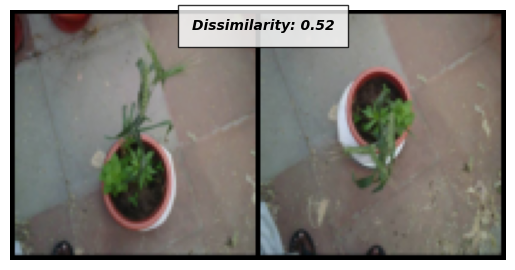

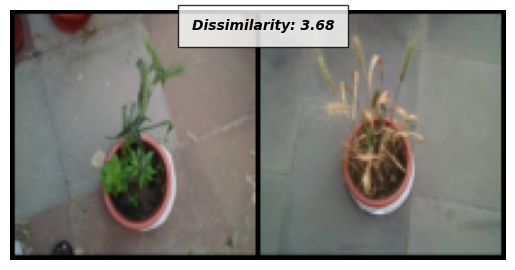

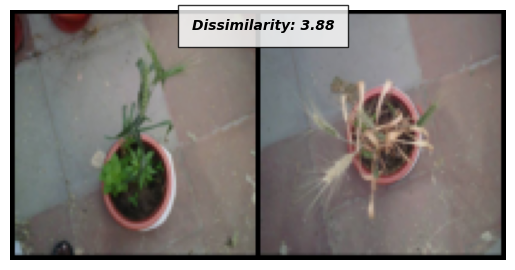

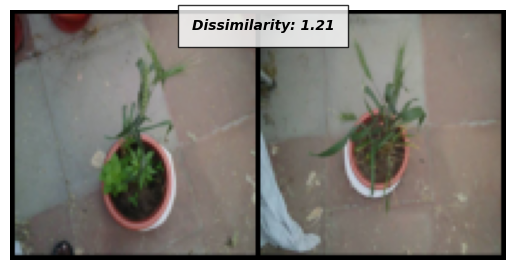

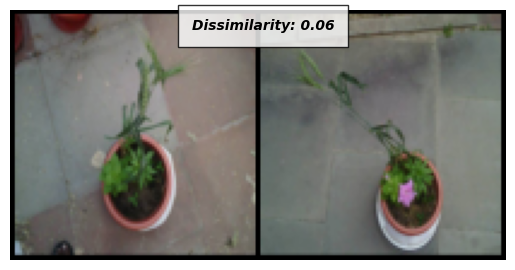

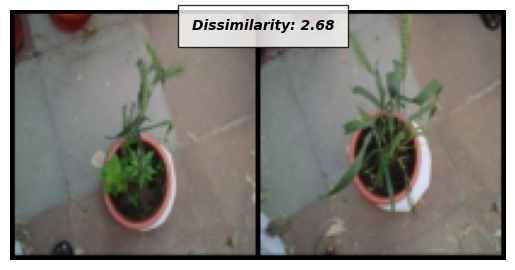

In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./Wheat_RGB_testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, label1 = next(dataiter)

for i in range(8):
    # Iterate over 8 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Get the class names of the images
    class_name_x0 = folder_dataset_test.classes[int(label1[0].item())]
    class_name_x1 = folder_dataset_test.classes[int(label2[0].item())]

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0, x1)
    euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
    # manhattan_distance = torch.norm(output1 - output2, p=1, dim=1)
    # kl_divergence = F.kl_div(F.log_softmax(output1, dim=1), F.softmax(output2, dim=1), reduction='batchmean')

    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')